https://github.com/AmritK10/MNIST-CNN/tree/master
Need to find already low res MNIST digits https://github.com/zatserkl/mnist_resolution/tree/master
 or we need to do pooling (max pooling)


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [4]:
# Print dimensions of the original images
print("Original Train Images Shape:", train_images.shape)
print("Original Test Images Shape:", test_images.shape)

Original Train Images Shape: (60000, 28, 28)
Original Test Images Shape: (10000, 28, 28)


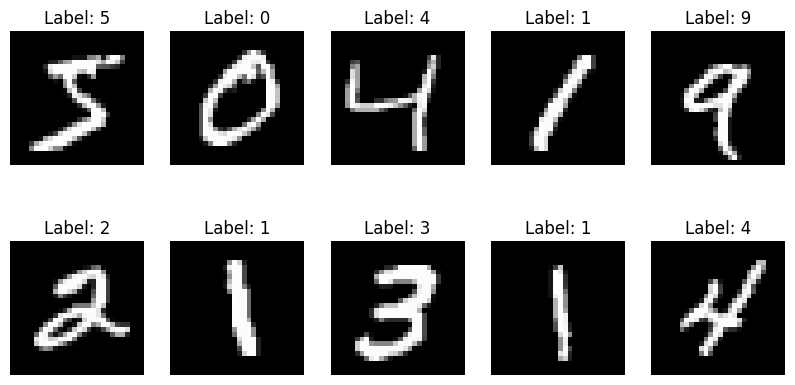

In [5]:
# Display some original images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

In [6]:
# Reshape images to 4D tensors (height, width, channels)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Define the pooling layer
pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='valid')

# Apply max pooling to the images
train_images_pooled = pooling_layer(train_images)
test_images_pooled = pooling_layer(test_images)

# Normalize pixel values to be between 0 and 1
train_images_pooled = train_images_pooled / 255.0
test_images_pooled = test_images_pooled / 255.0

print("Pooled Train Images Shape:", train_images_pooled.shape)

Pooled Train Images Shape: (60000, 7, 7, 1)


In [7]:
'''
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Define the pooling layer
pooling_layer = tf.keras.layers.AveragePooling2D(pool_size=(4, 4), strides=(4, 4), padding='valid')

# Apply pooling to the images
train_images_pooled = pooling_layer(train_images)
test_images_pooled = pooling_layer(test_images)

# Normalize pixel values to be between 0 and 1
train_images_pooled = train_images_pooled / 255.0
test_images_pooled = test_images_pooled / 255.0
print("Pooled Train Images Shape:", train_images_pooled.shape)
'''

'\ntrain_images = train_images.reshape(train_images.shape[0], 28, 28, 1)\ntest_images = test_images.reshape(test_images.shape[0], 28, 28, 1)\n\n# Define the pooling layer\npooling_layer = tf.keras.layers.AveragePooling2D(pool_size=(4, 4), strides=(4, 4), padding=\'valid\')\n\n# Apply pooling to the images\ntrain_images_pooled = pooling_layer(train_images)\ntest_images_pooled = pooling_layer(test_images)\n\n# Normalize pixel values to be between 0 and 1\ntrain_images_pooled = train_images_pooled / 255.0\ntest_images_pooled = test_images_pooled / 255.0\nprint("Pooled Train Images Shape:", train_images_pooled.shape)\n'

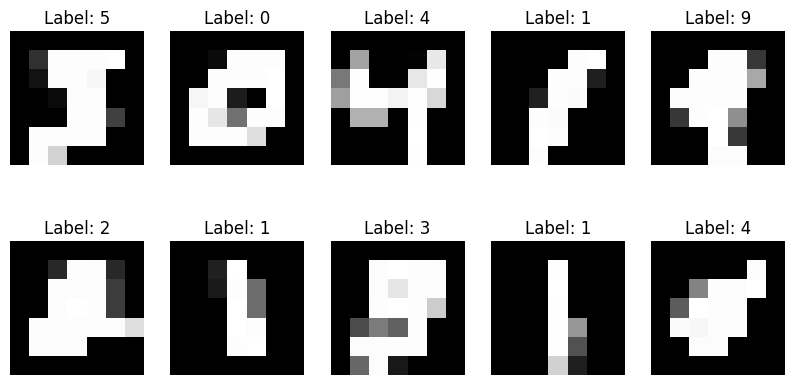

In [8]:
# Display some original images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images_pooled[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

In [9]:
# Reshape images to 3D tensors (height, width, channels)
train_images = train_images_pooled
test_images = test_images_pooled

In [10]:
# Define the CNN model with padding
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(7, 7, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


/Users/alanzhang/Library/Python/3.10/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), verbose=2)

Epoch 1/10
1875/1875 - 5s - 3ms/step - accuracy: 0.8105 - loss: 0.5781 - val_accuracy: 0.8638 - val_loss: 0.4137
Epoch 2/10
1875/1875 - 5s - 2ms/step - accuracy: 0.8820 - loss: 0.3558 - val_accuracy: 0.8874 - val_loss: 0.3393
Epoch 3/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8926 - loss: 0.3217 - val_accuracy: 0.8919 - val_loss: 0.3257
Epoch 4/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9000 - loss: 0.3022 - val_accuracy: 0.9000 - val_loss: 0.3064
Epoch 5/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9042 - loss: 0.2863 - val_accuracy: 0.8986 - val_loss: 0.3129
Epoch 6/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9082 - loss: 0.2743 - val_accuracy: 0.8936 - val_loss: 0.3179
Epoch 7/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9096 - loss: 0.2665 - val_accuracy: 0.9041 - val_loss: 0.3000
Epoch 8/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9127 - loss: 0.2578 - val_accuracy: 0.9132 - val_loss: 0.2735
Epoch 9/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9158 - loss: 0.2497 - val_accuracy: 0.9070 - 

In [13]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 90.74%


In [14]:
# Mini-batch Bootstrap resampling for confidence interval estimation
n_iterations = 10
#batch_size = 100  # Adjust batch size as needed
permutation_test_accuracies = []

for i in range(n_iterations):
    print(f'Iteration: {i+1}')

    indices = np.random.choice(train_images.shape[0], size=100, replace=True)
    indices_tensor = tf.convert_to_tensor(indices)  # Convert numpy array to tensor
    resampled_images = tf.gather(train_images, indices_tensor)
    resampled_labels = tf.gather(train_labels, indices_tensor)

    permuted_train_labels = np.random.permutation(resampled_labels)
    
    model.fit(resampled_images, permuted_train_labels, epochs=10, verbose=0)
    
    # Evaluate model on test data
    _, acc = model.evaluate(test_images, test_labels, verbose=0)
    permutation_test_accuracies.append(acc)  # Append accuracy value to the list
    print(f'Accuracy: {acc*100:.2f}%')

original_accuracy = test_acc
p_value = (np.sum(np.array(permutation_test_accuracies) >= original_accuracy) + 1) / (n_iterations + 1)

print("p-value:", p_value)

alpha = 0.05
z_score = stats.norm.ppf(1 - alpha / 2)

# Compute the standard error of the permutation test accuracies
std_error = np.std(permutation_test_accuracies) / np.sqrt(n_iterations)

# Compute the margin of error
margin_of_error = z_score * std_error

# Calculate the lower and upper bounds of the confidence interval
lower_bound = original_accuracy - margin_of_error
upper_bound = original_accuracy + margin_of_error

print("p-value:", p_value)
print("95% Confidence Interval:", (lower_bound, upper_bound))


Iteration: 1
Accuracy: 19.49%
Iteration: 2
Accuracy: 25.04%
Iteration: 3
Accuracy: 25.03%
Iteration: 4
Accuracy: 15.54%
Iteration: 5
Accuracy: 13.71%
Iteration: 6
Accuracy: 14.66%
Iteration: 7
Accuracy: 9.15%
Iteration: 8
Accuracy: 10.01%
Iteration: 9
Accuracy: 16.89%
Iteration: 10
Accuracy: 16.25%
p-value: 0.09090909090909091
p-value: 0.09090909090909091
95% Confidence Interval: (0.87561341956591, 0.9391866044666828)


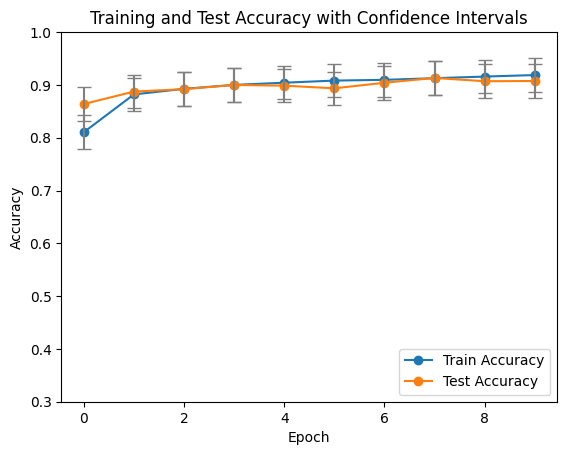

In [17]:


# Assume upper_bound and lower_bound are scalar values

# Plot training and test accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

# Plot confidence intervals
for epoch, (train_acc, test_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy'])):
    plt.errorbar(epoch, train_acc, yerr=margin_of_error, fmt='none', ecolor='gray', capsize=5)
    plt.errorbar(epoch, test_acc, yerr=margin_of_error, fmt='none', ecolor='gray', capsize=5)

plt.title('Training and Test Accuracy with Confidence Intervals')
plt.show()
